# SINDy model selection: how to select / tune hyperparameters

An interactive version of this notebook is available on binder:   [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/urban-fasel/I-X_workshop_2025/HEAD?labpath=4_SINDy_model_selection.ipynb)

- k-fold cross-validation: Brunton et al. 2016 https://www.pnas.org/doi/abs/10.1073/pnas.1517384113
- Akaike information criteria: Mangan et al 2017 https://royalsocietypublishing.org/doi/full/10.1098/rspa.2017.0009
- Stability selection: Maddu et al 2022 https://royalsocietypublishing.org/doi/full/10.1098/rspa.2021.0916
- This tutorial is using Lorenz system dynamics: 



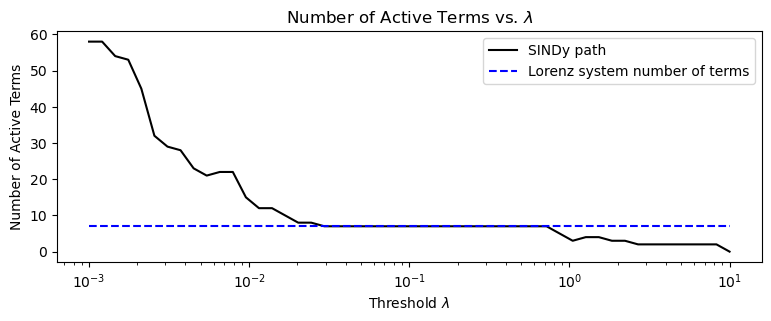

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import pysindy as ps
import warnings

# ignore warnings for sweeps over lambda -> e.g. remove all coefficients = trivial solution warning ...
warnings.filterwarnings('ignore', category=UserWarning)

# -----------------------------------------------------------------------------
# 1. Helper Functions
# -----------------------------------------------------------------------------

# Lorenz system
def lorenz_system(t, x, params):
    dx = params[0] * (x[1] - x[0])
    dy = x[0] * (params[1] - x[2]) - x[1]
    dz = x[0] * x[1] - params[2] * x[2]
    return [dx, dy, dz]   


# -----------------------------------------------------------------------------
# 2. Generate Data: Lorenz system
# -----------------------------------------------------------------------------

x0 = [-8, 8, 27]
dt = 0.001
t_final = 20
t = np.arange(0, t_final, dt)
sigma, rho, beta = 10, 28, 8/3
lorenz_params = [sigma, rho, beta]
sol = solve_ivp(lorenz_system, (0, t_final), x0, 
                       t_eval=t, args=(lorenz_params,), rtol=1e-12, atol=1e-12)
x = sol.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.01
x_noisy = x + sig * np.std(x) * np.random.randn(*x.shape)


# -----------------------------------------------------------------------------
# SINDy-path: sweep over lambda, starting from LS solution (lambda = 0)
# -----------------------------------------------------------------------------

# Use pySINDy to build and identify the model
# The library is automatically built, and derivatives are computed internally.
poly_library = ps.PolynomialLibrary(degree=3)

lambda_path = np.logspace(-3, 1, 50)
nonzero_terms = np.zeros(len(lambda_path))

for i, lambda_val in enumerate(lambda_path):
    # fit SINDy model
    optimizer = ps.STLSQ(threshold=lambda_val)
    model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
    model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
    # Get the coefficient matrix
    coefficients = model.coefficients()
    # Count the number of non-zero terms
    nonzero_terms[i] = np.count_nonzero(coefficients)

# Plot: Number of active terms vs. lambda
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_path, nonzero_terms, 'k-', label='SINDy path')

# Lorenz system has 7 non-zero terms (3 in x_dot, 2 in y_dot, 2 in z_dot)
nat = 7 
plt.semilogx([lambda_path[0], lambda_path[-1]], [nat, nat], 'b--', label='Lorenz system number of terms')

plt.xlabel('Threshold $\lambda$')
plt.ylabel('Number of Active Terms')
plt.legend()
plt.grid(False)
plt.title('Number of Active Terms vs. $\lambda$')
plt.show()


Optimal threshold found via cross-validation: 0.3728


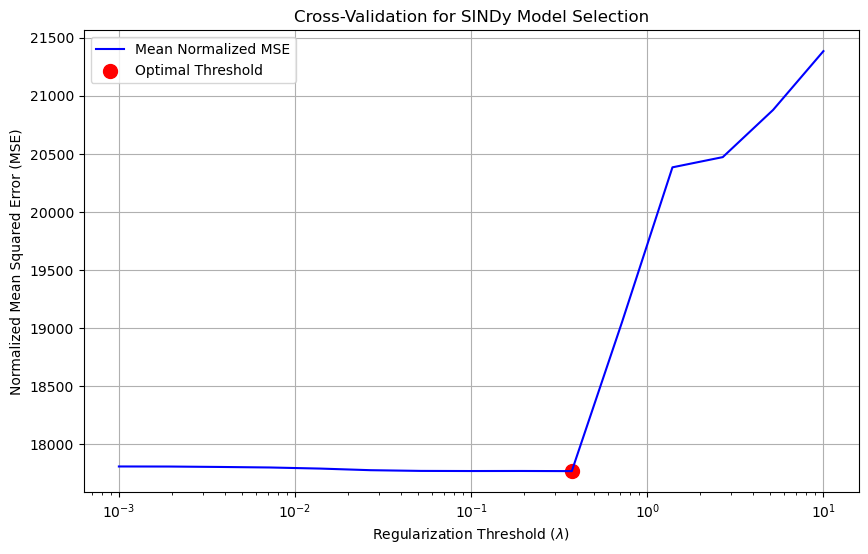


Final SINDy model with optimal threshold:
(x0)' = -9.873 x0 + 9.886 x1
(x1)' = 27.764 x0 + -0.918 x1 + -0.995 x0 x2
(x2)' = -2.673 x2 + 1.001 x0 x1


In [2]:
# -----------------------------------------------------------------------------
# 4. k-fold cross-validation
# -----------------------------------------------------------------------------

# Pre-compute time derivatives
x_dot_noisy = ps.FiniteDifference(axis=0, order=4)._differentiate(x_noisy, t)

# Define SINDy library
library = ps.PolynomialLibrary(degree=3)

# Perform Cross-Validation to find optimal threshold
thresholds = np.logspace(-3, 1, 15) # Range of regularization thresholds
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = np.zeros((len(thresholds), k))

for i, threshold in enumerate(thresholds):
    # Initialize the SINDy model for this threshold
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=library
    )
    # Iterate through each fold
    for j, (train_idx, val_idx) in enumerate(kf.split(x_noisy)):
        # Fit on training data
        model.fit(x_noisy[train_idx], t=t[train_idx], x_dot=x_dot_noisy[train_idx])
        
        # Calculate MSE on validation data using model.score()
        mse_scores[i, j] = model.score(x_noisy[val_idx], t=t[val_idx], x_dot=x_dot_noisy[val_idx], metric=mean_squared_error)

# Find Optimal Model
mean_mse = np.mean(mse_scores, axis=1)
best_threshold_idx = np.argmin(mean_mse)
best_threshold = thresholds[best_threshold_idx]

print(f"Optimal threshold found via cross-validation: {best_threshold:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogx(thresholds, mean_mse, 'b-', label='Mean Normalized MSE')
plt.scatter(thresholds[best_threshold_idx], mean_mse[best_threshold_idx], color='red', s=100, label='Optimal Threshold')
plt.xlabel('Regularization Threshold ($\lambda$)')
plt.ylabel('Normalized Mean Squared Error (MSE)')
plt.title('Cross-Validation for SINDy Model Selection')
plt.legend()
plt.grid(True)
plt.show()

# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=best_threshold),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()


Final SINDy model with optimal threshold:
(x0)' = -9.873 x0 + 9.886 x1
(x1)' = 0.047 1 + 27.764 x0 + -0.918 x1 + -0.995 x0 x2
(x2)' = 0.052 x0 + -0.047 x1 + -2.673 x2 + 1.001 x0 x1


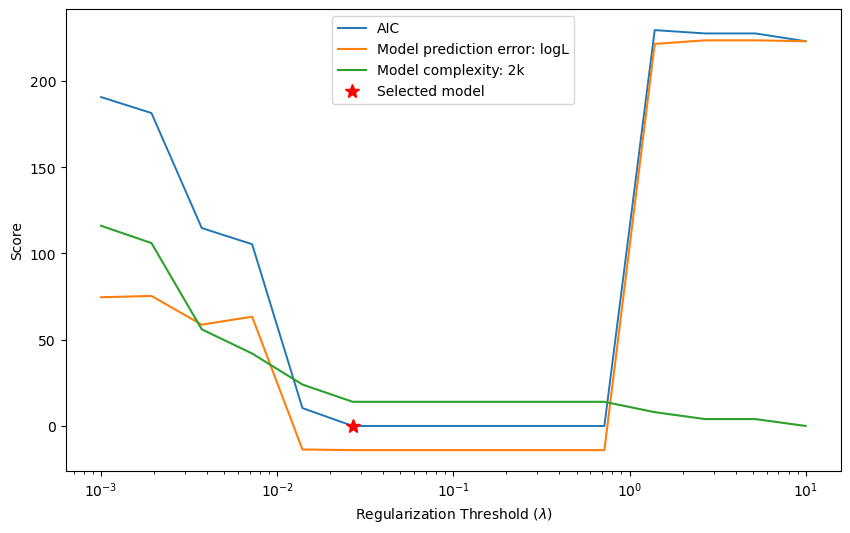

In [3]:
# -----------------------------------------------------------------------------
# 5. Prediction error and sparsity (Akaike Information Criteria)
# -----------------------------------------------------------------------------

# Range of regularization thresholds: number of lambdas (models with different complexity) to sweep through
nl_aic = 15
lambda_aic = np.logspace(-3, 1, nl_aic)

# Prediction error parameters: randomly select nm initial conditions from time series data
nm = 10 # number of initial conditions for prediction
tF = 0.2 # model prediction time span
tspanE = np.arange(0, tF, dt)
ltE = len(tspanE) # time steps model prediction
lt = len(x) # total model prediction time - length pred time: needed for comparison

np.random.seed(1)
x0i = np.random.choice(lt - ltE, nm, replace=False) # random selection of initial conditions
x0e = x[x0i, :] # random initial cond

k_aic = np.zeros(nl_aic)
logL_aic = np.zeros(nl_aic)
aic_score = np.zeros(nl_aic)
mse_sim = np.zeros((nl_aic, nm))

nonzero_terms = np.zeros(len(lambda_aic))

# sweep over lambda-path
for i, lambda_val in enumerate(lambda_aic):
    # fit SINDy model
    optimizer = ps.STLSQ(threshold=lambda_val)
    model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
    model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
    
    # run model predictions from different initial conditions using
    for j in range(nm):
        # integrate SINDy model
        x_test_sim = model.simulate(x0e[j, :], tspanE ) #, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        x_test = x[x0i[j]:x0i[j]+ltE, :]
        # model prediction error
        mse_sim[i, j] = np.sum((x_test - x_test_sim) ** 2)
    
    k_aic[i] = np.count_nonzero(model.coefficients()) # Count the number of non-zero terms -> sparsity
    logL_aic[i] = nm * np.log(np.mean(mse_sim[i, :]**2)) # log mean prediction error
    aic_score[i] = logL_aic[i] + 2 * k_aic[i]
    
# find minimum score
minAIC = np.min(aic_score)
min_AIC_idx = np.argmin(aic_score)
lambda_AIC_min = lambda_aic[min_AIC_idx]

# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=lambda_AIC_min),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the final scores, prediction error, and 2k curves
plt.semilogx(thresholds, aic_score - minAIC, linewidth=1.4, label='AIC')
plt.semilogx(thresholds, logL_aic - minAIC, label='Model prediction error: logL')
plt.semilogx(thresholds, 2 * k_aic, label='Model complexity: 2k')

# Plot a marker at the selected model (minimum AIC)
plt.plot(thresholds[min_AIC_idx], aic_score[min_AIC_idx] - minAIC, 'r*', markersize=10, label='Selected model')

plt.ylabel('Score')
plt.xlabel('Regularization Threshold ($\lambda$)')
plt.legend()
plt.show()


In [4]:
# -----------------------------------------------------------------------------
# 5 Stability Selection 
# -----------------------------------------------------------------------------

# Add less noise to better visualize method
np.random.seed(1)
sig = 0.001
x_noisy = x + sig * np.std(x) * np.random.randn(*x.shape)


# Compute Derivative
x_dot_noisy = ps.FiniteDifference(axis=0, order=4)._differentiate(x_noisy, t)

# # Pool Data
polyorder = 3
n = 3 # number of states
poly_library = ps.PolynomialLibrary(degree=polyorder, include_bias=True)

# Get the number of features
poly_library.fit(x_noisy) # need to fit a model to get number of features
m = poly_library.n_output_features_

# Number of lambdas (models with different complexity) to sweep through
nl = 15
lambda_list = np.logspace(1, -3, nl)
nT = x_noisy.shape[0] // 2  # Size of subsamples: 1/2 number of measurements
B = 50                 # Number of models subsampled (Maddu et al recommended 250)
np.random.seed(1)

coeffs = np.zeros((n, m, nl, B))
coeffs_active = np.zeros((n, m, nl, B), dtype=bool)

# Subsample data
for j in range(B):
    indices = np.random.choice(nT * 2, nT, replace=False)

    # For all subsamples: sweep over model complexity and store model structure
    for i, lambda_val in enumerate(lambda_list):
        optimizer = ps.STLSQ(threshold=lambda_val)
        model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
        
        model.fit(x_noisy[indices, :], t=dt, x_dot=x_dot_noisy[indices, :])

        coeffs[:, :, i, j] = model.coefficients()
        coeffs_active[:, :, i, j] = (coeffs[:, :, i, j] != 0) # active terms (boolean)


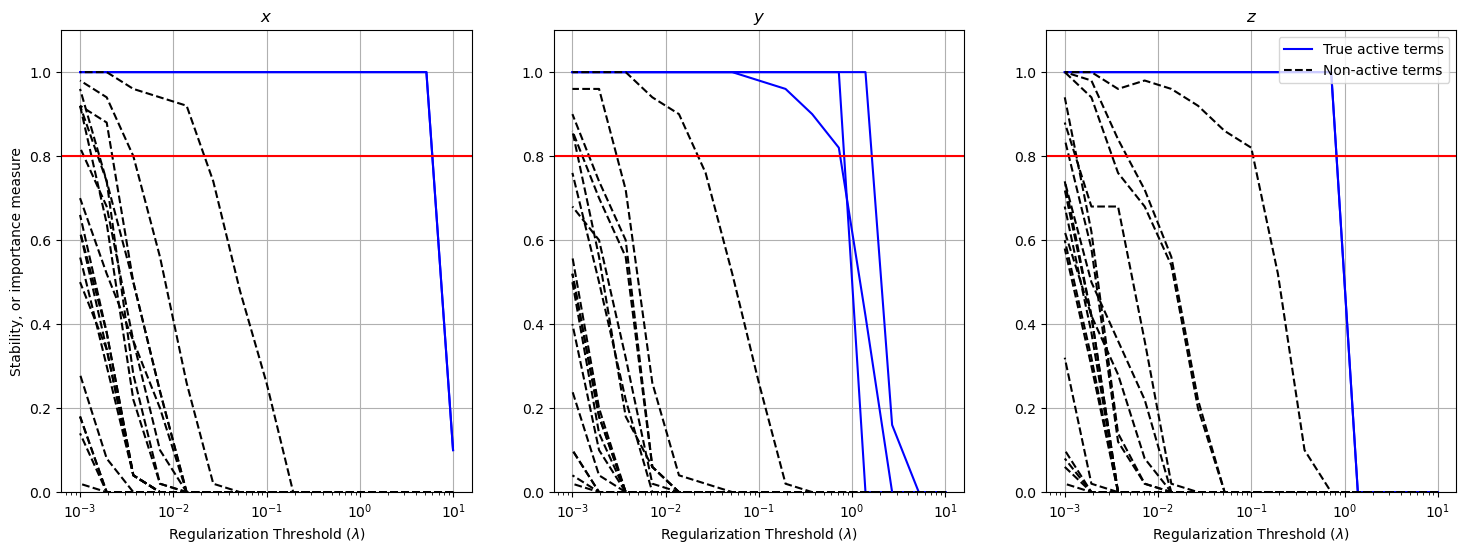

In [9]:
# -----------------------------------------------------------------------------
# Plotting the Stability Paths
# -----------------------------------------------------------------------------

sStable = 0.8 # "stable inclusion probability"
states = ['x', 'y', 'z']

# Calculate the mean inclusion probability over the subsamples
XiEM = np.mean(coeffs_active, axis=3)

# Manually define the "true active terms" of the Lorenz system
active = np.zeros((m, n), dtype=bool)
active[[1, 2], 0] = True  # Terms 2 and 3 for state 1 (x)
active[[1, 2, 6], 1] = True # Terms 2, 3, and 7 for state 2 (y)
active[[3, 5], 2] = True # Terms 4 and 6 for state 3 (z)

# Create the figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(n):
    ax = axs[i]
    
    # Plot the stability path for "true active terms" (blue line)   
    ax.semilogx(lambda_list, XiEM[i, active[:, i], :].T, 'b', label='True active terms')
    
    # Plot the stability path for "non-active terms" (black dashed line)
    ax.semilogx(lambda_list, XiEM[i, ~active[:, i], :].T, 'k--', label='Non-active terms')

    # Plot the stability threshold line
    ax.axhline(sStable, color='r', linestyle='-')

    ax.set_ylim([0, 1.1])
    ax.set_title(f'${states[i]}$')
    ax.set_xlabel('Regularization Threshold ($\lambda$)')
    ax.grid(True)

axs[0].set_ylabel('Stability, or importance measure')
handles, labels = axs[0].get_legend_handles_labels()
axs[2].legend(handles[1:3], labels[1:3],loc='upper right')
plt.show()


In [10]:
# Visual inspection of stability paths -> e.g. large gap around lambda = 5*10^-1
lambdaSS = 5*10**-1

# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=lambdaSS),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()


Final SINDy model with optimal threshold:
(x0)' = -9.991 x0 + 9.992 x1
(x1)' = 27.972 x0 + -0.990 x1 + -0.999 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
